## Trained model in Google Colab

In [ ]:
from google.colab import drive
import os

In [ ]:
# 1. Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Create the project path
# This matches the "Google Drive" folder requirement in your instructions
PROJECT_PATH = '/content/drive/MyDrive/ece5831-2025-final-project'
PROCESSED_PATH = os.path.join(PROJECT_PATH, 'processed_data')
os.makedirs(PROCESSED_PATH, exist_ok=True)
print(f"Project Workspace: {PROJECT_PATH}")

Project Workspace: /content/drive/MyDrive/ece5831-2025-final-project


In [ ]:
# 3. Install required libraries
!pip install facenet-pytorch kaggle

### Authenticating to Kaggle to download datasets. 

In [ ]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

# Move it to the correct location for the API to find it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API Key configured successfully!")

Saving kaggle.json to kaggle.json
Kaggle API Key configured successfully!


In [ ]:
import kagglehub
import os

print("Downloading dataset...")

# Download latest version
dataset_path = kagglehub.dataset_download("xdxd003/ff-c23")

print(f"\nDataset is downloaded at: {dataset_path}")

100%|██████████| 16.7G/16.7G [01:37<00:00, 184MB/s]

Extracting files...



Dataset is downloaded at: /root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1


In [ ]:
# !ls -R /root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1

# assume the path structure will start with the main folder:
# Let's try to list the contents of from root folder:
!ls -R /root/.cache/kagglehub/datasets

/root/.cache/kagglehub/datasets:
xdxd003

/root/.cache/kagglehub/datasets/xdxd003:
ff-c23

/root/.cache/kagglehub/datasets/xdxd003/ff-c23:
1.complete  versions

/root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions:
1

/root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1:
FaceForensics++_C23

/root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1/FaceForensics++_C23:
csv		   Deepfakes  FaceShifter  NeuralTextures
DeepFakeDetection  Face2Face  FaceSwap	   original

/root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1/FaceForensics++_C23/csv:
DeepFakeDetection.csv  FaceSwap.csv		   NeuralTextures.csv
Deepfakes.csv	       FF++_Metadata.csv	   original.csv
Face2Face.csv	       FF++_Metadata_Shuffled.csv
FaceShifter.csv        Mean_Data.csv

/root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1/FaceForensics++_C23/DeepFakeDetection:
01_02__meeting_serious__YVGY8LOK.mp4
01_02__outside_talking_still_laughing__YVGY8LOK.mp4
01_02__talking_against_wall__YVGY8LOK.mp4
01_02__wal

In [ ]:
import os

# Define path
dataset_path = '/content/drive/MyDrive/ece5831-2025-final-project/processed_data'

# Count files
real_count = len(os.listdir(os.path.join(dataset_path, 'real')))
fake_count = len(os.listdir(os.path.join(dataset_path, 'fake')))

print(f"--- DATASET REPORT ---")
print(f"Real Faces: {real_count}")
print(f"Fake Faces: {fake_count}")
print(f"Total: {real_count + fake_count}")

if (real_count + fake_count) > 1000:
    print("\nDataset are ready for training")
else:
    print("\nCheck data")

--- DATASET REPORT ---
Real Faces: 15000
Fake Faces: 43492
Total: 58492

Dataset are ready for training


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import glob
import os

# --- CONFIGURATION ---
BATCH_SIZE = 32
IMG_SIZE = 128
PROJECT_PATH = '/content/drive/MyDrive/ece5831-2025-final-project'
DATASET_PATH = os.path.join(PROJECT_PATH, 'processed_data')

# --- DATASET CLASS ---
class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load Real Images (Label: 0)
        real_path = os.path.join(root_dir, 'real', '*.jpg')
        real_files = glob.glob(real_path)
        self.image_paths.extend(real_files)
        self.labels.extend([0] * len(real_files))

        # Load Fake Images (Label: 1)
        fake_path = os.path.join(root_dir, 'fake', '*.jpg')
        fake_files = glob.glob(fake_path)
        self.image_paths.extend(fake_files)
        self.labels.extend([1] * len(fake_files))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# --- TRANSFORMS & LOADERS ---
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

print("Preparing Dataset...")
full_dataset = DeepfakeDataset(DATASET_PATH, transform=transform)

# Split: 80% Train, 20% Validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Data Ready: {len(train_dataset)} Training samples, {len(val_dataset)} Validation samples.")

Preparing Dataset...
Data Ready: 46793 Training samples, 11699 Validation samples.


### Copying dataset from google drive to google colab

In [ ]:
import shutil
import os
import time

# Source (Slow Google Drive)
source_dir = '/content/drive/MyDrive/ece5831-2025-final-project/processed_data'

# Destination (Fast Local Disk)
dest_dir = '/content/fast_data'

print(f"Copy data")
print(f"From: {source_dir}")
print(f"To:   {dest_dir}")

start = time.time()

# Remove existing if any (to avoid duplicates)
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)

# Copy the entire folder structure
shutil.copytree(source_dir, dest_dir)

end = time.time()
print(f"Copy took {(end - start)/60:.1f} minutes.")


Copy data
From: /content/drive/MyDrive/ece5831-2025-final-project/processed_data
To:   /content/fast_data
Copy took 9.3 minutes.


### Trained the model after changing dataset location yet it stopped because it was learning black pixels instead of images

In [ ]:
import torch.optim as optim
import time
import copy

# --- SETUP ---
total_samples = len(full_dataset)
n_classes = 2
count_real = len([x for x in full_dataset.labels if x == 0])
count_fake = len([x for x in full_dataset.labels if x == 1])

# Weighted Loss for Imbalance
weight_real = total_samples / (n_classes * count_real)
weight_fake = total_samples / (n_classes * count_fake)
class_weights = torch.tensor([weight_real, weight_fake]).to(device)
print(f"Using Class Weights -> Real: {weight_real:.2f}, Fake: {weight_fake:.2f}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- TRAINING FUNCTION ---
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    val_acc_history = []

    print(f"--- Starting 20 Epochs of Training ---")

    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), os.path.join(PROJECT_PATH, 'best_model.pth'))
                print(f"  -> New best acc: {best_acc:.4f}")

            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
            if phase == 'train':
                train_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_acc_history

# --- START ---
trained_model, train_loss, val_acc = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=20
)

Using Class Weights -> Real: 1.95, Fake: 0.67
--- Starting 20 Epochs of Training ---

Epoch 1/20
----------
Train Loss: 0.7469 Acc: 0.6656
Val Loss: 0.6931 Acc: 0.7428
  -> New best acc: 0.7428

Epoch 2/20
----------
Train Loss: 0.6930 Acc: 0.7437
Val Loss: 0.6929 Acc: 0.7428

Epoch 3/20
----------
Train Loss: 0.6930 Acc: 0.7381
Val Loss: 0.6931 Acc: 0.7428

Epoch 4/20
----------
Train Loss: 0.6930 Acc: 0.7437
Val Loss: 0.6931 Acc: 0.7428

Epoch 5/20
----------
Train Loss: 0.6930 Acc: 0.7437
Val Loss: 0.6929 Acc: 0.7428

Epoch 6/20
----------
Train Loss: 0.6930 Acc: 0.7437
Val Loss: 0.6930 Acc: 0.7428

Epoch 7/20
----------
Train Loss: 0.6930 Acc: 0.7437
Val Loss: 0.6930 Acc: 0.7428

Epoch 8/20
----------
Train Loss: 0.6930 Acc: 0.7437
Val Loss: 0.6929 Acc: 0.7428

Epoch 9/20
----------


KeyboardInterrupt: 

checking the model again to see if it runs well in new dataset

--- VISUAL CHECK: THESE MUST BE CLEAR FACES ---


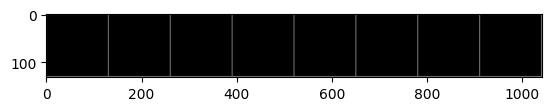

Labels: 1 1 0 1 1 0 0 0
(0 = Real, 1 = Fake)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
print("--- VISUAL CHECK: THESE MUST BE CLEAR FACES ---")
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(8)))
print("(0 = Real, 1 = Fake)")

## Preparing dataset Loader for 4th time

In [ ]:
import cv2
import os
import torch
import numpy as np
from facenet_pytorch import MTCNN
from tqdm.notebook import tqdm

# --- 1. CONFIGURATION ---
# Check for the path file from the previous step
if os.path.exists("dataset_path.txt"):
    with open("dataset_path.txt", "r") as f:
        DATA_ROOT = f.read().strip()
else:
    # Fallback to the path we saw in your logs
    DATA_ROOT = "/kaggle/input/ff-c23/FaceForensics++_C23"

print(f"Processing from: {DATA_ROOT}")

PROJECT_PATH = '/content/drive/MyDrive/ece5831-2025-final-project'
PROCESSED_PATH = os.path.join(PROJECT_PATH, 'processed_data')

# Real Videos
REAL_SOURCE = os.path.join(DATA_ROOT, "original")

# --- MODIFIED: SELECTED ONLY 3 FAKE SOURCES ---
# This reduces imbalance and prevents the model from getting overwhelmed
FAKE_SOURCES = [
    os.path.join(DATA_ROOT, "Deepfakes"),
    os.path.join(DATA_ROOT, "Face2Face"),
    os.path.join(DATA_ROOT, "FaceSwap")
    # Excluded: NeuralTextures, DeepFakeDetection (to keep dataset balanced)
]

# --- 2. SETUP ENGINE ---
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

# CRITICAL FIX: post_process=False prevents black images
mtcnn = MTCNN(image_size=128, margin=0, keep_all=False, post_process=False, device=device).to(device)

def find_videos(folder_path):
    mp4_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.mp4'):
                mp4_files.append(os.path.join(root, file))
    return mp4_files

def process_folder(input_dir, label):
    # Create output folder (e.g., processed_data/real or processed_data/fake)
    save_dir = os.path.join(PROCESSED_PATH, label)
    os.makedirs(save_dir, exist_ok=True)

    if not os.path.exists(input_dir):
        print(f"Skipped (Not found): {input_dir}")
        return

    video_files = find_videos(input_dir)
    source_name = os.path.basename(input_dir)
    print(f"Found {len(video_files)} videos in {source_name} ({label})")

    # Process
    for video_path in tqdm(video_files, desc=f"Extracting {source_name}"):
        try:
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            if total_frames <= 0:
                cap.release()
                continue

            # Extract 15 frames per video
            indices = np.linspace(0, total_frames-1, 15, dtype=int)

            for idx in indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret: continue

                # Convert BGR (OpenCV) to RGB (MTCNN)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Detect Face
                face = mtcnn(frame_rgb, save_path=None)

                if face is not None:
                    # FIX: Convert raw float tensor to 0-255 numpy array
                    img = face.permute(1, 2, 0).cpu().numpy().astype('uint8')

                    # Generate filename
                    vid_name = os.path.splitext(os.path.basename(video_path))[0]
                    save_name = f"{vid_name}_frame{idx}.jpg"

                    # Save (Convert RGB back to BGR for OpenCV saving)
                    cv2.imwrite(os.path.join(save_dir, save_name), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            cap.release()
        except Exception:
            pass

# --- 3. EXECUTE ---
if __name__ == "__main__":
    print("--- STARTING OPTIMIZED EXTRACTION ---")

    # 1. Process Real
    process_folder(REAL_SOURCE, "real")

    # 2. Process Selected Fakes (Deepfakes, Face2Face, FaceSwap)
    for fake_dir in FAKE_SOURCES:
        process_folder(fake_dir, "fake")

    print("\nExtraction Complete. Images are saved and visible.")

Processing from: /kaggle/input/ff-c23/FaceForensics++_C23
Running on: cuda:0
--- STARTING OPTIMIZED EXTRACTION ---
Found 1000 videos in original (real)


Extracting original:   0%|          | 0/1000 [00:00<?, ?it/s]

Found 1000 videos in Deepfakes (fake)


Extracting Deepfakes:   0%|          | 0/1000 [00:00<?, ?it/s]

Found 1000 videos in Face2Face (fake)


Extracting Face2Face:   0%|          | 0/1000 [00:00<?, ?it/s]

Found 1000 videos in FaceSwap (fake)


Extracting FaceSwap:   0%|          | 0/1000 [00:00<?, ?it/s]


Extraction Complete. Images are saved and visible.


### Checking whether datasets are present with faces and not just black screen

--- DATASET VISUAL CHECK ---

Checking REAL images from: /content/drive/MyDrive/ece5831-2025-final-project/processed_data/real


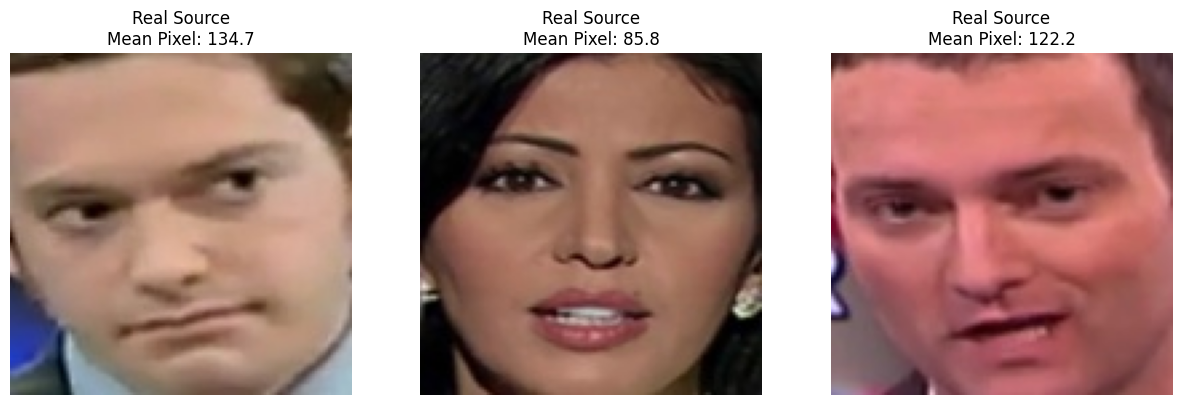


Checking FAKE images from: /content/drive/MyDrive/ece5831-2025-final-project/processed_data/fake


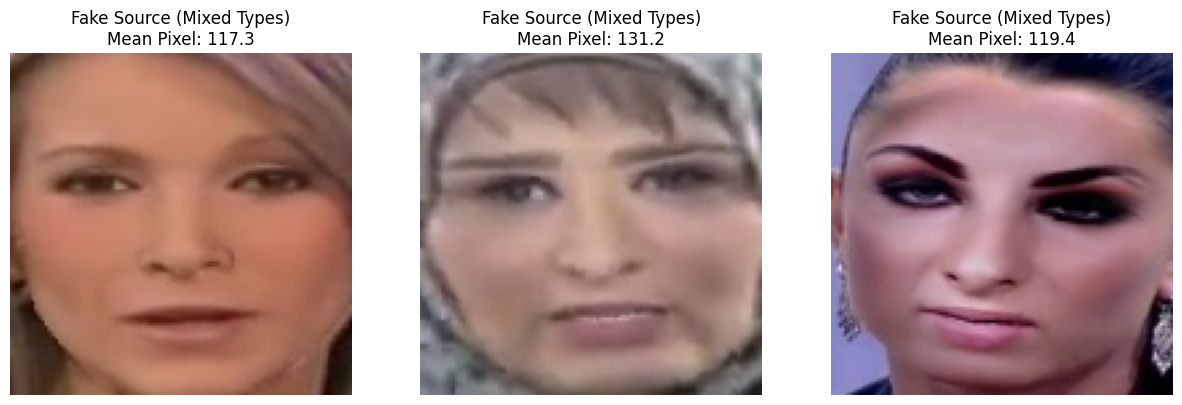


--- 📊 COUNT CHECK ---
Real Images: 15000
Fake Images: 28572


In [ ]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
import random

# --- CONFIGURATION ---
PROJECT_PATH = '/content/drive/MyDrive/ece5831-2025-final-project'
DATA_PATH = os.path.join(PROJECT_PATH, 'processed_data')

# Define the specific categories we extracted
categories = ['real', 'fake']
# Note: In your extraction loop, you merged all fakes into a single 'fake' folder
# or kept them separate?
# Based on my last code, they were saved into 'processed_data/real' and 'processed_data/fake'.
# However, to be safe, let's look at what actually exists.

def show_samples(folder_path, title, count=3):
    image_paths = glob.glob(os.path.join(folder_path, '*.jpg'))

    if len(image_paths) == 0:
        print(f"No images found in: {folder_path}")
        return

    # Pick random samples
    samples = random.sample(image_paths, min(len(image_paths), count))

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None: continue

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Check for "Black Image" bug (Pixel values should be spread out, not all near 0)
        mean_val = img.mean()

        plt.subplot(1, count, i+1)
        plt.imshow(img)
        plt.title(f"{title}\nMean Pixel: {mean_val:.1f}")
        plt.axis('off')
    plt.show()

# --- RUN CHECKS ---
print("--- DATASET VISUAL CHECK ---")

# 1. Check Real
real_path = os.path.join(DATA_PATH, 'real')
if os.path.exists(real_path):
    print(f"\nChecking REAL images from: {real_path}")
    show_samples(real_path, "Real Source")
else:
    print(f"ERROR: 'real' folder not found at {real_path}")

# 2. Check Fakes
fake_path = os.path.join(DATA_PATH, 'fake')
if os.path.exists(fake_path):
    print(f"\nChecking FAKE images from: {fake_path}")
    show_samples(fake_path, "Fake Source (Mixed Types)")
else:
    print(f"ERROR: 'fake' folder not found at {fake_path}")

# 3. Size Check
print("\n--- 📊 COUNT CHECK ---")
if os.path.exists(real_path):
    n_real = len(glob.glob(os.path.join(real_path, '*.jpg')))
    print(f"Real Images: {n_real}")

if os.path.exists(fake_path):
    n_fake = len(glob.glob(os.path.join(fake_path, '*.jpg')))
    print(f"Fake Images: {n_fake}")

now lets copy this dataset from drive to colab

In [ ]:
import shutil
import os
import time

# Source (Google Drive)
source_dir = '/content/drive/MyDrive/ece5831-2025-final-project/processed_data'

# Destination (Local Colab Runtime)
dest_dir = '/content/fast_data'

print(f"ACCELERATING DATASET")
print(f"Source: {source_dir}")
print(f"Dest:   {dest_dir}")

start = time.time()

# Clean up previous runs if any
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)

# Copy
shutil.copytree(source_dir, dest_dir)

end = time.time()
print(f"DONE! Copy took {(end - start)/60:.1f} minutes.")

ACCELERATING DATASET
Source: /content/drive/MyDrive/ece5831-2025-final-project/processed_data
Dest:   /content/fast_data
DONE! Copy took 6.3 minutes.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import glob
import os
import random

# --- CONFIGURATION ---
BATCH_SIZE = 64  # Good balance for A100
IMG_SIZE = 128
DATASET_PATH = '/content/fast_data' # Reading from the fast local copy

# --- DATASET CLASS ---
class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 1. Load Files
        real_files = glob.glob(os.path.join(root_dir, 'real', '*.jpg'))
        fake_files = glob.glob(os.path.join(root_dir, 'fake', '*.jpg'))

        print(f"Original: {len(real_files)} Real, {len(fake_files)} Fake")

        # 2. FORCE BALANCE (1:1 Split)
        # We limit fakes to match the number of reals
        min_len = min(len(real_files), len(fake_files))

        random.seed(42) # Consistent shuffle
        random.shuffle(real_files)
        random.shuffle(fake_files)

        real_files = real_files[:min_len]
        fake_files = fake_files[:min_len]

        print(f"Balanced: {len(real_files)} Real, {len(fake_files)} Fake")

        # 3. Combine
        self.image_paths = real_files + fake_files
        self.labels = [0] * len(real_files) + [1] * len(fake_files)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except:
            return self.__getitem__((idx + 1) % len(self))

# --- LOADERS ---
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

print("Preparing Dataset...")
full_dataset = DeepfakeDataset(DATASET_PATH, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Ready: {len(train_dataset)} Training samples, {len(val_dataset)} Validation samples.")

Preparing Dataset...
Original: 15000 Real, 28572 Fake
Balanced: 15000 Real, 15000 Fake
Ready: 24000 Training samples, 6000 Validation samples.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import copy
import os

# --- 1. MODEL ARCHITECTURE ---
class RobustCNN(nn.Module):
    def __init__(self):
        super(RobustCNN, self).__init__()
        # Input: 128x128
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2) # -> 64x64

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # -> 32x32

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # -> 16x16

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256) # -> 8x8

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), 0.1))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), 0.1))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), 0.1))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x)), 0.1))

        x = x.view(-1, 256 * 8 * 8)
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobustCNN().to(device)
criterion = nn.CrossEntropyLoss() # Balanced data = No weights needed
optimizer = optim.Adam(model.parameters(), lr=0.0005) # Good starting rate

# --- 2. TRAINING LOOP ---
def train_model(num_epochs=20):
    since = time.time()
    best_acc = 0.0

    print(f"--- Starting Training on {device} ---")

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save if best
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"  -> New best acc: ({best_acc:.4f})")

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Final Best Accuracy: {best_acc:.4f}')

# --- 3. RUN ---
train_model(num_epochs=20)

--- Starting Training on cuda ---

Epoch 1/20
----------
Train Loss: 0.7727 Acc: 0.5922
Val Loss: 0.5862 Acc: 0.6932
  -> New best acc: (0.6932)

Epoch 2/20
----------
Train Loss: 0.5719 Acc: 0.7003
Val Loss: 0.4962 Acc: 0.7643
  -> New best acc: (0.7643)

Epoch 3/20
----------
Train Loss: 0.4856 Acc: 0.7641
Val Loss: 0.4304 Acc: 0.7997
  -> New best acc: (0.7997)

Epoch 4/20
----------
Train Loss: 0.4021 Acc: 0.8130
Val Loss: 0.4024 Acc: 0.8210
  -> New best acc: (0.8210)

Epoch 5/20
----------
Train Loss: 0.3416 Acc: 0.8475
Val Loss: 0.2951 Acc: 0.8712
  -> New best acc: (0.8712)

Epoch 6/20
----------
Train Loss: 0.2779 Acc: 0.8808
Val Loss: 0.4898 Acc: 0.7810

Epoch 7/20
----------
Train Loss: 0.2259 Acc: 0.9051
Val Loss: 0.2981 Acc: 0.8817
  -> New best acc: (0.8817)

Epoch 8/20
----------
Train Loss: 0.1878 Acc: 0.9227
Val Loss: 0.2860 Acc: 0.8892
  -> New best acc: (0.8892)

Epoch 9/20
----------
Train Loss: 0.1524 Acc: 0.9394
Val Loss: 0.2309 Acc: 0.9103
  -> New best acc: (0.9

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# --- 1. SETUP ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 128
BATCH_SIZE = 64

# Re-initialize the model structure (must match training exactly)
model = RobustCNN().to(device)

# Load the weights from the file we just saved
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

RobustCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

--- STARTING FINAL EVALUATION ---

Final Accuracy: 93.92%
False Positives (Real labeled as Fake): 154
False Negatives (Fake labeled as Real): 211

--- DETAILED REPORT ---
              precision    recall  f1-score   support

        Real       0.93      0.95      0.94      2965
        Fake       0.95      0.93      0.94      3035

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



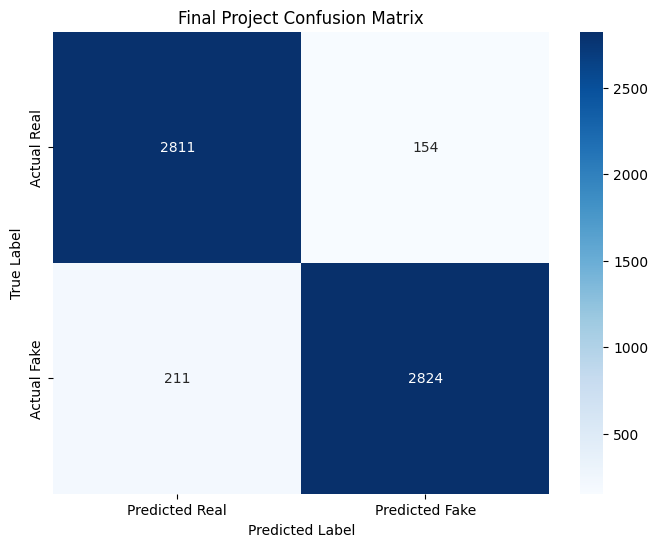

In [ ]:
print("--- STARTING FINAL EVALUATION ---")

# --- 2. GET PREDICTIONS ---
y_true = []
y_pred = []

# We don't need gradients for testing, it's faster
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- 3. GENERATE METRICS ---
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nFinal Accuracy: {(tp+tn)/(tn+fp+fn+tp)*100:.2f}%")
print(f"False Positives (Real labeled as Fake): {fp}")
print(f"False Negatives (Fake labeled as Real): {fn}")

# Classification Report
print("\n--- DETAILED REPORT ---")
target_names = ['Real', 'Fake']
print(classification_report(y_true, y_pred, target_names=target_names))

# --- 4. PLOT CHART ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.title('Final Project Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()